In [2]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [174]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatching import MapMatching
import copy
from tracker import StaticTracker
from simulation import NuscenesSimulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, gt_relative_pos)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, nusc_map)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, debug_info, mm_results

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #odometry


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 0
Number of extended tracks before run() 0
last_output [0. 0.]
xlim [1122.5960584670038, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0


No handles with labels found to put in legend.


frame 1
Number of point tracks before run() 45
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.89224952e+00 -1.07880760e+00  4.75946502e-03  3.69680995e+01
  5.33584103e+01] static_cars_flag True
last_output [-0.00238388 -0.00175519]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1119.3484809377017, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 1 cost_true [3.453257380551553] cost_mean [1.2903147211000618]
frame 2


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 61
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 0.20206786 -0.12456649]
xlim [1118.8456230627937, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 1 cost_true [3.2645734604227155] cost_mean [1.2949732847312134]
frame 3
Number of point tracks before run() 79
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
last_output [ 0.39193256 -0.23231528]
xlim [1118.5894775523313, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 1 cost_true [4.273943394252251] cost_mean [1.769883944515411]
frame 4
Number of point tracks before run() 89
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 2 cost_true [3.4808646696702352, 1.0259090609401809] cost_mean [1.3000806044905853, 1.0588250398543257]
frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.473968786934862, -0.8309384110681072, 0.008763073398827622) (0.0, -0.7984407801983737, 0.005279222948958802)
last_output [ 1.93377247 -1.11309556]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 2 cost_true [4.017013565069796, 1.0369062983525033] cost_mean [1.611289925838149, 1.0516056789751824]
frame 10
Number of point tracks before run() 128
Number of extended tracks before run() 2
last_output [ 2.11488225 -1.22015614]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 2 cost_true [3.7553269577027932, 1.0458520630439594] cost_mean [1.4916871822672086, 1.0094252497970355]
frame 11
Number of point tracks before run() 146
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
last_output [ 2.36299614 -1.36428361]
xlim 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 3 cost_true [3.0337371639816295, 1.0667297795746036, 6.2052581811390155] cost_mean [1.2428385307609844, 1.076306273180551, 5.610700148057202]
frame 20


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10244926407252875, -0.8505316929808977, 0.008375957411768496) (0.0, -0.7611884108741793, 0.004837982287319682)
last_output [ 5.22206423 -3.0605675 ]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 3 cost_true [3.158632034575094, 1.0642257064679972, 3.1470411628847166] cost_mean [1.195941723049137, 1.0493870996180092, 1.8988611962002129]
frame 21
Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  1
last_output [ 5.48924313 -3.219253  ]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [3.5347385729773624, 1.095767657444343, 3.1778289788125447] cost_mean [1.4758165853560774, 1.039292843143761, 1.9926622139868455]
frame 22
Number of point tracks before run() 179
Number of extended tracks before run() 3
Updating extended object track =  2

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [1.0613489147121806, 2.2305758212370166, 1.204084857321076] cost_mean [1.0298019528074975, 1.9013794716948142, 1.1125352481182575]
frame 37


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [11.42412017 -6.88562818]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [1.078935077551939, 2.3289757995692018, 1.2140955744420383] cost_mean [1.0495523180187727, 1.983895229162848, 1.1040276205177715]
frame 38
Number of point tracks before run() 163
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
last_output [11.78350416 -7.11222859]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 3 cost_true [1.0779301212875536, 1.8061809105909687, 1.481151988881443] cost_mean [1.0597064743537294, 1.540210472694957, 1.2734626700929979]
frame 39
Number of point tracks before run() 163
Number of extended tracks before run() 3
Updating extended object track =  1
Updating ext

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 4 cost_true [1.0491732045091773, 1.7487179261555463, 1.3243406732292224, 17.001698183395394] cost_mean [1.060768091282573, 1.48315438792068, 1.171023187999657, 12.733893391678702]
frame 40


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.33093813e+01 -2.25500601e+00  1.39481818e-02  5.20111317e+01
  6.08266067e+01] static_cars_flag True
last_output [12.39715726 -7.4987825 ]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [1.0588301737412977, 2.225219371127512, 1.2595973195580106, 16.114016110906384, 75.03180326634029] cost_mean [1.0480424656407399, 1.901572720364748, 1.1586866469472492, 12.188427320338992, 64.88528117667973]
frame 41


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.219254092812031, -0.6881738265123866, 0.0027553034263395238) (0.0, -0.7558133936868898, 0.002490611487342371)
last_output [13.10404205 -7.93698413]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 5
n_polynoms 5 cost_true [1.1021465187956214, 2.5384314241335626, 1.3240102443091843, 13.226698018581436, 83.66248587850588] cost_mean [1.048800814889494, 2.136529246179484, 1.158941784418267, 9.984641973708218, 73.11569794424705]
frame 42
Number of point tracks before run() 148
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2
Tracks are similar! do not open a new trk (-0.011708373919444182, -0.696129087959593, 0.0025596614521113748) (0.0, -0.6171240387556051, -0.0005390066323600643)
last_o

xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 5 cost_true [1.036787330322688, 2.0873145200588623, 1.2298652970100785, 19.665404408969867, 75.64803416270249] cost_mean [1.0236933852902013, 1.8834596799908863, 1.1899322686644733, 16.870710573197652, 68.7085751357999]
frame 53
Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
created an extended object! [ 3.61278163e+01 -1.74707586e+00  7.97014738e-03  6.08663558e+01
  7.72560631e+01] static_cars_flag True
last_output [ 17.8618073  -10.88401393]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 6 cost_true [1.094062875682424, 2.5931756036080156, 1.3276047145040732, 16.169397144593155, 77.7939125472547, 24.07918958038619] cost_mean [1.0493021071987207, 2.2913370657822267, 1.2505575148046875, 13.125520248883955, 68.7833462599747, 17.345490273450153]
frame 54


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 18.19942757 -11.09726727]
xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 6 cost_true [1.111013618706544, 1.8917807819182957, 1.3307005890905228, 16.201974068344487, 75.33812871920607, 18.811822631100817] cost_mean [1.05410476509986, 1.744978691250009, 1.2349472589314359, 13.784022698117289, 67.1937696048657, 13.738606003050412]
frame 55
Number of point tracks before run() 183
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  3
Tracks are similar! do not open a new trk (2.6590194300238483, -0.9572790032618992, 0.006792357395128

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 7 cost_true [1.0016745041069584, 1.7420905629735515, 1.1713759086791358, 17.977523042487853, 74.82722065586114, 22.27394145402065, 1.0503682808920138] cost_mean [1.0550575715134733, 1.5113254973995147, 1.1293241488342707, 15.991011259784846, 66.69003999947682, 17.68671555655948, 1.0342582102154705]
frame 60


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.9045039751333261, -0.6465187395741593, 0.0012080242497311934) (0.0, -0.686292749693885, 0.0033715689307623766)
last_output [ 20.63894722 -12.63862008]
xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 7 cost_true [1.0639706636913768, 2.0681433518827688, 1.1765430474284033, 24.824780820460425, 76.16372615917435, 25.808364793821426, 1.0832377443459804] cost_mean [1.0156393653334612, 1.874258210696322, 1.1896288962678543, 22.48005736246713, 70.70136925474996, 21.37678301203619, 1.0616903992133193]
frame 61
Number of point tracks before run() 166
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating ex

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 8 cost_true [1.1295163726432087, 2.5044970182093222, 1.302775171271129, 16.20700838886303, 92.91565675767572, 21.774318157134473, 1.1500150770613091, 21.157403061183015] cost_mean [1.0809762233908893, 2.2052350713258297, 1.3439926008726042, 16.571770556930293, 87.51573220103268, 19.021203123951235, 1.1345554696605826, 17.489499478752293]
frame 69


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 8
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.789613402882015, -0.6306800979234252, 0.0011833923054119766) (0.0, -0.6481952568816159, -6.2598122832311565e-06)
last_output [ 24.57409977 -15.16208948]
xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 8 cost_true [1.1131507394834572, 2.0057841238066487, 1.332798426726892, 23.06280978880871, 76.1458629473291, 30.20911414621626, 1.1360239604979396, 26.586897524107947] cost_mean [1.0954680441973452, 1.9775650608739015, 1.3232063422058071, 22.584006456433922, 73.02157621310957, 27.74844402068713, 1.1210463150677097, 23.31672374379404]
frame 70
Number of point tracks before run() 131
Number of extended tracks before run() 8
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Tracks are similar! do not open a new trk (0.34037309833471685, -0.6903622111532549, 0.0010833458742952648) (0.0, -

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 9 cost_true [1.1798333548454218, 2.2256439218070336, 1.490905910079688, 19.60166159942326, 80.19932192939025, 25.474262234844737, 1.2234997414865345, 23.934510146610915, 2.5053470489183] cost_mean [1.1430957487339637, 2.176831962024639, 1.5634978059590978, 20.851927043511022, 83.90692405269449, 24.71015015569283, 1.2225277560559327, 21.589067740170037, 2.6302864800364407]
frame 74


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 9
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  7


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8089044833622612, -0.6372365744317675, 0.0009112619439793179) (0.0, -0.6497660305544262, 2.9664576214140868e-05)
last_output [ 26.76912013 -16.53214512]
xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 9 cost_true [1.056898264243886, 1.7432024995274993, 1.4104234337991395, 26.165077387558483, 76.52242119510876, 29.8588534242633, 1.044401867451834, 26.432298846850163, 2.0010164160123898] cost_mean [1.0392791930968601, 1.623132054563243, 1.5099275321495995, 27.149906102503408, 74.22565535065448, 29.313367290753842, 1.0959197376901846, 23.988048575559688, 2.2344965447175578]
frame 75
Number of point tracks before run() 125
Number of extended tracks before run() 9
Updating extended object track =  5
created an extended object! [-3.40589363e+01  5.73540782e-02 -3.75385528e-03  9.07931058e+01
  1.01747653e+02] static_cars_flag True
last_output [ 27.16778753 -16.77631865]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 10 cost_true [1.1106139593215516, 2.0744097381231943, 1.2858377428855379, 18.849623420206978, 88.73286047632631, 26.90275392773143, 1.1442128745040059, 26.608001171391766, 2.232539020541452, 24.085084023864002] cost_mean [1.0942146897028533, 1.916883298501211, 1.3928771947604675, 19.766262147041346, 92.1511061045857, 26.55452067441029, 1.1185051362192358, 24.193061296413166, 2.2184495923120706, 18.26153636776455]
frame 76


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 10
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.8841811228556451, -0.629093763808016, 0.000848204628077961) (0.0, -0.6309989535331141, -0.00014025407573037317)
last_output [ 27.51670621 -16.99005159]
xlim [1118.5894775523313, 1232.2810178399359] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 10 cost_true [1.1042970995681363, 1.8986460895171924, 1.2977844843611854, 22.506273270767778, 71.65264726756061, 29.56989993352413, 1.0832757599629161, 26.818252353239608, 1.9423717700372916, 30.007939886905344] cost_mean [1.060153216293463, 1.898319722547605, 1.3727264986301264, 24.810265399843132, 76.86089742354288, 29.72317984177463, 1.1188438513624674, 25.27332882925418, 2.050435581863398, 22.75706991927072]
frame 77
Number of point tracks before run() 125
Number of extended tracks before run() 10
Updating extended object track =  1
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  7
Updating extended object track =  9

frame 85
Number of point tracks before run() 147
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  6
Tracks are similar! do not open a new trk (-0.1473694124864453, -0.6695991812564532, 0.000992081054027631) (0.0, -0.6349639044826858, 0.00018211083336864154)
last_output [ 31.79307933 -19.56547269]
xlim [1118.5894775523313, 1277.4308664420637] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 7 cost_true [1.6306016397058722, 28.78435531774815, 77.26300521772767, 34.68983644423255, 28.377478803832954, 1.9855666889827321, 28.03259862308097] cost_mean [1.9648644385810023, 33.61851981480269, 87.88936162081961, 39.93706375642778, 28.70219435937724, 2.588914994738075, 25.31776987102288]
frame 86
Number of point tracks before run() 146
Number of extended tracks before run() 7
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Tracks are similar! do not open 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1315.825239804503] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 4 cost_true [30.89210046574622, 29.354734879227497, 30.9644293450416, 16.31580798637901] cost_mean [37.90696345412135, 33.77517742389719, 33.599971843828406, 22.51791879319413]
frame 95


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.19586076314521428, -0.676390268517427, 0.0010112107168872466) (0.0, -0.6295058566326472, -0.0011135471803374226)
last_output [ 36.30671099 -22.24619211]
xlim [1118.5894775523313, 1315.897614259832] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 4 cost_true [34.861883259111835, 34.79012241676001, 39.208813476517115, 13.356084344866447] cost_mean [41.76621059785988, 41.28118637706663, 39.47917767718554, 18.10957562876957]
frame 96
Number of point tracks before run() 152
Number of extended tracks before run() 4
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Tracks are similar! do not open a new trk (-0.20403605793594126, -0.6842287992942607, 0.0012928428971658555) (0.0, -0.5975115386090072, -0.0007293845494303245)
last_output [ 37.15262396 -22.74705994]
x

xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 4 cost_true [38.05242190979343, 32.04669733611029, 40.227778033335035, 22.84257616518592] cost_mean [39.63623096480457, 39.705588758608314, 36.760616558664985, 31.98164621798521]
frame 107
Number of point tracks before run() 146
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
created an extended object! [-7.41832981e+01  8.66958240e-01 -5.79110085e-03  1.21288856e+02
  1.37687660e+02] static_cars_flag True
last_output [ 42.34247066 -25.88714297]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [34.393499619292854, 35.375559190305374, 38.41424621054985, 21.624151907663286, 25.138952203135865] cost_mean [43.543541180066285, 41.54111157961285, 34.80341796420236, 31.155968810894205, 23.30334671723484]
frame 108


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4420528073277534, -0.662560081580717, 0.0010121066598233453) (0.0, -0.6073966552275919, -0.0018574038782965044)
last_output [ 43.19783313 -26.40098848]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [32.82502199746706, 28.31136356701367, 36.36093228527, 18.650165271884013, 19.981670050325054] cost_mean [41.62492828310125, 38.53280710420458, 34.790790864647335, 27.895898801291807, 17.538237019354924]
frame 109
Number of point tracks before run() 149
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
Tracks are similar! do not open a new trk (0.005792980937239456, -0.6759081325606995, 0.0011762886288227924) (0.0, -0.588231610550364, -0.000521446542797253)
last_output [ 43.66190035 -26.68474323]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_poly

frame 119
Number of point tracks before run() 142
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Tracks are similar! do not open a new trk (0.3552296775298749, -0.6085993715875117, -0.0016744879592244671) (0.0, -0.6209383402110463, 0.0003841341398795729)
last_output [ 48.86614298 -29.92401186]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 5 cost_true [33.409434737520634, 32.43114243502368, 39.00593032533171, 28.288884476347583, 28.095824708459844] cost_mean [42.32802062192722, 38.877669790814195, 33.04095851531273, 32.72677797499487, 28.04883434483826]
frame 120
Number of point tracks before run() 143
Number of extended tracks before run() 5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 6 cost_true [37.60802952440629, 35.618119513595154, 39.75960153488588, 23.80822136232522, 32.905237419590826, 42.970202227932226] cost_mean [43.713505464462806, 40.39213976999296, 38.05924582686203, 28.289332053566646, 33.854031589878694, 43.37338975904745]
frame 124


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 51.47959606 -31.57072234]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 6 cost_true [36.56575931746921, 33.980584278824416, 41.91359317916598, 24.355285690978967, 22.728526376567594, 37.08694587374646] cost_mean [39.55403049404004, 42.84421017943622, 38.5359860193467, 30.232574891669152, 18.75493863763403, 36.945046395969605]
frame 125
Number of point tracks before run() 166
Number of extended tracks before run() 6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Tracks are similar! do not open a new trk (-0.19983971158582658, -0.6069107360716879, -0.0017460075043

xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [35.214185231745105, 32.382361028161526, 39.25382909926544, 21.45085150520025, 38.59963810311129] cost_mean [42.90394916703135, 40.58644329575051, 32.3239990922339, 21.523175662112845, 38.33107494390229]
frame 134
Number of point tracks before run() 158
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Tracks are similar! do not open a new trk (0.042189204457214746, -0.6078684709573855, -0.0017211277216870361) (0.0, -0.6533968575046964, 0.0008711

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 5 cost_true [40.788110387441414, 45.58444293073553, 25.528983460647822, 42.67986934773283, 23.153090482808164] cost_mean [49.35477876313627, 33.369136212847906, 21.360001096556086, 49.19452252450267, 19.68593584034924]
frame 141


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 59.99854952 -37.03350825]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 5 cost_true [34.12754385256126, 40.3846432785152, 31.869349597304755, 43.00214554784381, 29.017561790698814] cost_mean [39.28894150391445, 32.079632209595516, 35.33454127025983, 41.19875411349548, 32.951076200763836]
frame 142
Number of point tracks before run() 168
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Tracks are similar! do not open a new trk (0.14482575626871252, -0.6074904203260195, -0.001718784831333742) (0.0, -0.6467504691330532, -5.119461928313027e-05)
last_output [ 60.89924625 -37.59173385]
xlim [1118.5894775523313, 1386.832082545597] self.

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 6 cost_true [35.161303042598824, 36.43585823778939, 19.98526689407999, 34.03962769370119, 18.912799295758365, 18.93822392773169] cost_mean [41.76497945193376, 24.42728636527829, 21.917676429342947, 44.37385253910659, 20.52163739072709, 18.646209441253987]
frame 146


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 163
Number of extended tracks before run() 6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.4216291869793398, -0.6301842123275088, -0.0017278525508368228) (0.0, -0.6128045477158058, 0.00034130724316043455)
last_output [ 62.7375933  -38.76032119]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 6 cost_true [39.82736036564917, 45.70773691207292, 28.96729477753067, 43.9796992679669, 26.9591181869361, 21.823251137618534] cost_mean [44.837564122947306, 31.998018677890077, 28.25365970096435, 51.85026018231318, 25.932147330581774, 21.26372716073387]
frame 147
Number of point tracks before run() 161
Number of extended tracks before run() 6
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Tracks are similar! do not open a new trk (1.4203295809345775, -0.6537993206763785, 0.001004903662067456) (0.0, -0.6562683063601177, 0.0020868885094668752)
last_

Tracks are similar! do not open a new trk (0.29023492127623474, -0.6304298605109191, -0.0017026238083373564) (0.0, -0.5922010065795626, -0.0010154873508825173)
last_output [ 68.1700843  -42.17543373]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 5
n_polynoms 5 cost_true [36.99607268635143, 19.36422201589621, 43.67300212486402, 17.29460735704341, 17.39905386566063] cost_mean [22.176414088564165, 22.493911557519297, 65.71943856860243, 20.34451117335595, 19.277392605549423]
frame 157
Number of point tracks before run() 161
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Tracks are similar! do not open a new trk (1.961016510227572, -0.6275404931414612, -0.0017026238083373577) (0.0, -0.6514990645140684, 0.004103147571200221)
last_output [ 68.62716763 -42.45910461]
xlim [1118.5894775523313, 1386.832082

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 6 cost_true [36.89106090882561, 22.6655244197364, 35.933592003199706, 18.602149671167222, 17.731647378006684, 36.70484069372289] cost_mean [22.703971957152493, 24.654843490879777, 31.89188456843223, 21.521956888546907, 19.614726173807888, 51.986610686045935]
frame 160


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 70.35755939 -43.55598716]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 6 cost_true [43.37283690461987, 24.00503391178342, 36.80426098748465, 19.52477035761951, 19.66855408333011, 42.158824060063374] cost_mean [25.98037837516248, 25.983373698621847, 48.31353470291783, 24.125294976074382, 23.251255455421987, 70.72556938279932]
frame 161
Number of point tracks before run() 165
Number of extended tracks before run() 6
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Tracks are similar! do not open a new trk (0.2840713682911489, -0.6740355812522408, 0.0017314122144118267) (0.0, -0.5713466158256667, -0.0028895861441233894)
last_output [ 70

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 7 cost_true [33.08921164492923, 20.218810957988097, 36.1940813023925, 18.96498598742256, 18.924841340581406, 35.4931371433411, 21.60556259565063] cost_mean [18.624345209160275, 26.812820722884734, 63.92490219111196, 24.728838293695524, 23.02730678147789, 62.157109677463396, 34.35343382403597]
frame 167


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 7
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.44059633249829844, -0.6764881264551895, 0.0014445940611308066) (0.0, -0.586386400233211, -0.002675897506502641)
last_output [ 73.72075198 -45.67331085]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 7 cost_true [45.91901944376175, 29.562504063563534, 49.09457331105085, 26.952918717322962, 23.310521174939787, 44.37787735835428, 16.783672162117153] cost_mean [25.18379408916429, 31.913234391663902, 71.49372567239654, 30.00409880980126, 27.04328999242743, 71.12087891687179, 26.918327528778505]
frame 168
Number of point tracks before run() 157
Number of extended tracks before run() 7
Updating extended object track =  6
last_output [ 74.16143529 -45.94606298]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 7 cost_true [33.58073976320487, 33.631119525288376, 43.313933746583466, 30.9459949169115, 26.096898829183775, 

last_output [ 79.52548418 -49.36429502]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 3 cost_true [46.45502735469948, 46.77740544669859, 22.239586769838713] cost_mean [59.946939441461915, 59.443805866418344, 38.241195378367465]
frame 180
Number of point tracks before run() 192
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Tracks are similar! do not open a new trk (-0.12909569184291358, -0.6654644042938433, 0.0017758872496213462) (0.0, -0.6471108073718278, -0.0002430209034645115)
last_output [ 79.89488632 -49.6137649 ]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 3 cost_true [43.72101800502991, 39.115726659414534, 18.76272787376902] cost_mean 

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 4 cost_true [45.85276960987914, 36.416388667857746, 18.366720261120122, 24.894341863296972] cost_mean [70.31240074899084, 65.18214637370235, 32.635723045371, 45.29357541148498]
frame 187


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 204
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 83.48242238 -51.95625069]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 4 cost_true [44.028892399738844, 30.174921582120785, 18.699285879100316, 45.07665006649899] cost_mean [72.4634664695163, 53.184345551745714, 33.14523178709482, 78.15487543271131]
frame 188
Number of point tracks before run() 203
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
last_output [ 83.906279   -52.22875934]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 4 cost_true [32.20371667217386, 24.566518988042663, 23.92591726885991, 41.679550682175254] cost_mean [53.75612892791892, 41.46420353795975, 43.541413017131376, 73.98152770971164]
frame 189
Number of point tracks before run() 211
Number of extended tracks before run() 4
Updati

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [50.901359011586564, 39.337283193042474, 16.356896681703773, 34.211014067452936, 25.82262899946736] cost_mean [82.97591991507468, 57.66593209651311, 30.151653765829767, 59.25604806837191, 28.66914359317692]
frame 191


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 204
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.85401978e+01  2.69922733e-01 -2.38116388e-03  1.61384019e+02
  1.81883100e+02] static_cars_flag True
last_output [ 85.03432532 -52.97925769]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 6 cost_true [38.18067927585229, 25.443704120369667, 20.19751583284112, 31.941329459563956, 27.854756913170736, 27.564083071544452] cost_mean [70.16658804370542, 49.21224311090337, 36.47306535302378, 57.729279037236616, 33.8546133956759, 32.79278872933316]
frame 192


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 192
Number of extended tracks before run() 6
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 85.79136565 -53.48244047]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 6 cost_true [47.64319082849585, 39.84325884892587, 23.090562261666403, 32.143457465236665, 21.596045387201166, 20.124931208485453] cost_mean [80.96829850690342, 64.23505550131048, 37.16730498910383, 71.80862430353902, 26.370761262145045, 22.48541417314883]
frame 193
Number of point tracks before run() 197
Number of extended tracks before run() 6
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  0
last_output [ 86.18239952 -53.74266905]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 5
n_polynoms 6 cost_true [47.613055088441996, 33.73941222042641, 17.694336325411527, 46.20500661094682,

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 5
n_polynoms 7 cost_true [48.1626043264485, 28.51448067355181, 24.065697744694297, 36.01693884431411, 17.670618299416613, 19.384189741987488, 72.3615858513505] cost_mean [71.43186454819543, 43.78484515978681, 40.882111881104166, 63.14438900682556, 22.343951775813373, 21.394367628658152, 110.42490889817313]
frame 196


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 188
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.21665672229867583, -0.5897778397291052, 0.002108120745834624) (0.0, -0.5989738801818654, 0.0020997145580618527)
last_output [ 87.35098172 -54.51712829]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 7 cost_true [36.98366422065507, 30.2505146943656, 19.92845745378654, 38.654626546619625, 20.707765192429314, 22.148930578108242, 86.62348379036358] cost_mean [74.18998164318843, 51.36780274469964, 34.96286655057727, 71.6233653405586, 25.756595701281014, 26.04575388810315, 132.39103122638622]
frame 197
Number of point tracks before run() 180
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
created an extended object! [-3.07274850e+01 -4.2355

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 8 cost_true [42.888916048858626, 29.448235234632865, 15.605825880443641, 30.11886641718695, 23.391998821530642, 22.316785501771243, 65.7949829742287, 23.286153125532692] cost_mean [73.02245738546735, 41.26065748747963, 29.79515535476079, 54.25561932269694, 30.913625731591075, 24.733889245885013, 100.64683521141251, 23.171817781543066]
frame 198


/home/kfir/workspace/RadarLocalization/dataset.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:259: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


last_output [ 88.45672792 -55.24598884]
xlim [1118.5894775523313, 1386.832082545597] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 8 cost_true [39.91519369730471, 27.619096759116605, 20.331773514768404, 44.9096023313724, 17.100788919813805, 18.697689496383063, 101.93396447725394, 17.853210961986257] cost_mean [73.81484830489265, 46.944169508645764, 38.16281311610291, 83.77511754779688, 22.285829803194535, 23.384643509729326, 155.52785040133858, 19.572744610071766]
frame 199
Number of point tracks before run() 183
Number of extended tracks before run() 8
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Tracks are similar! 

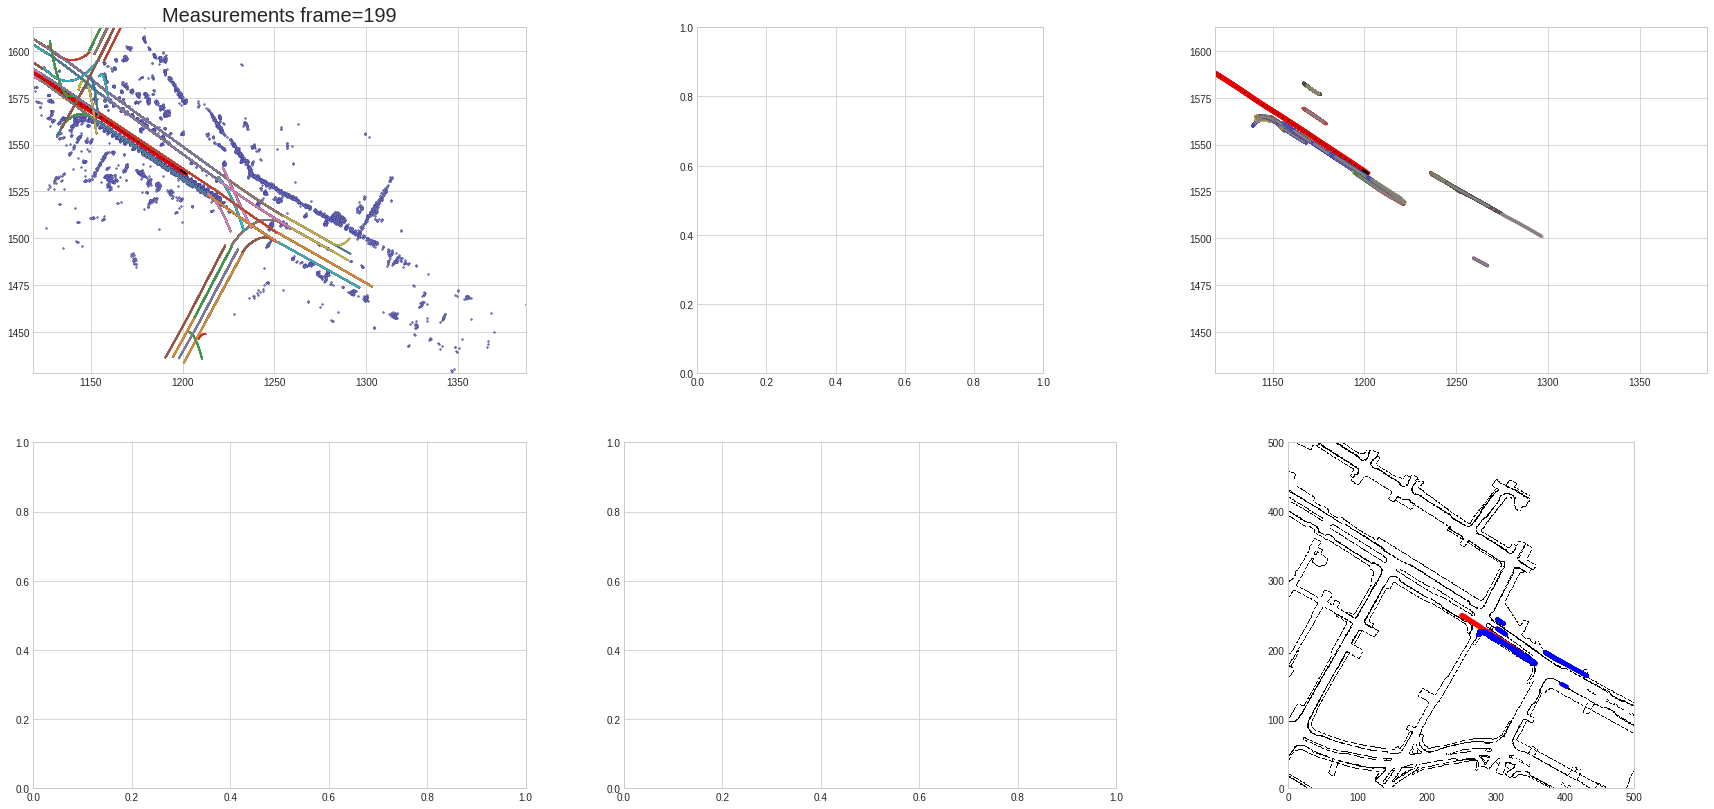

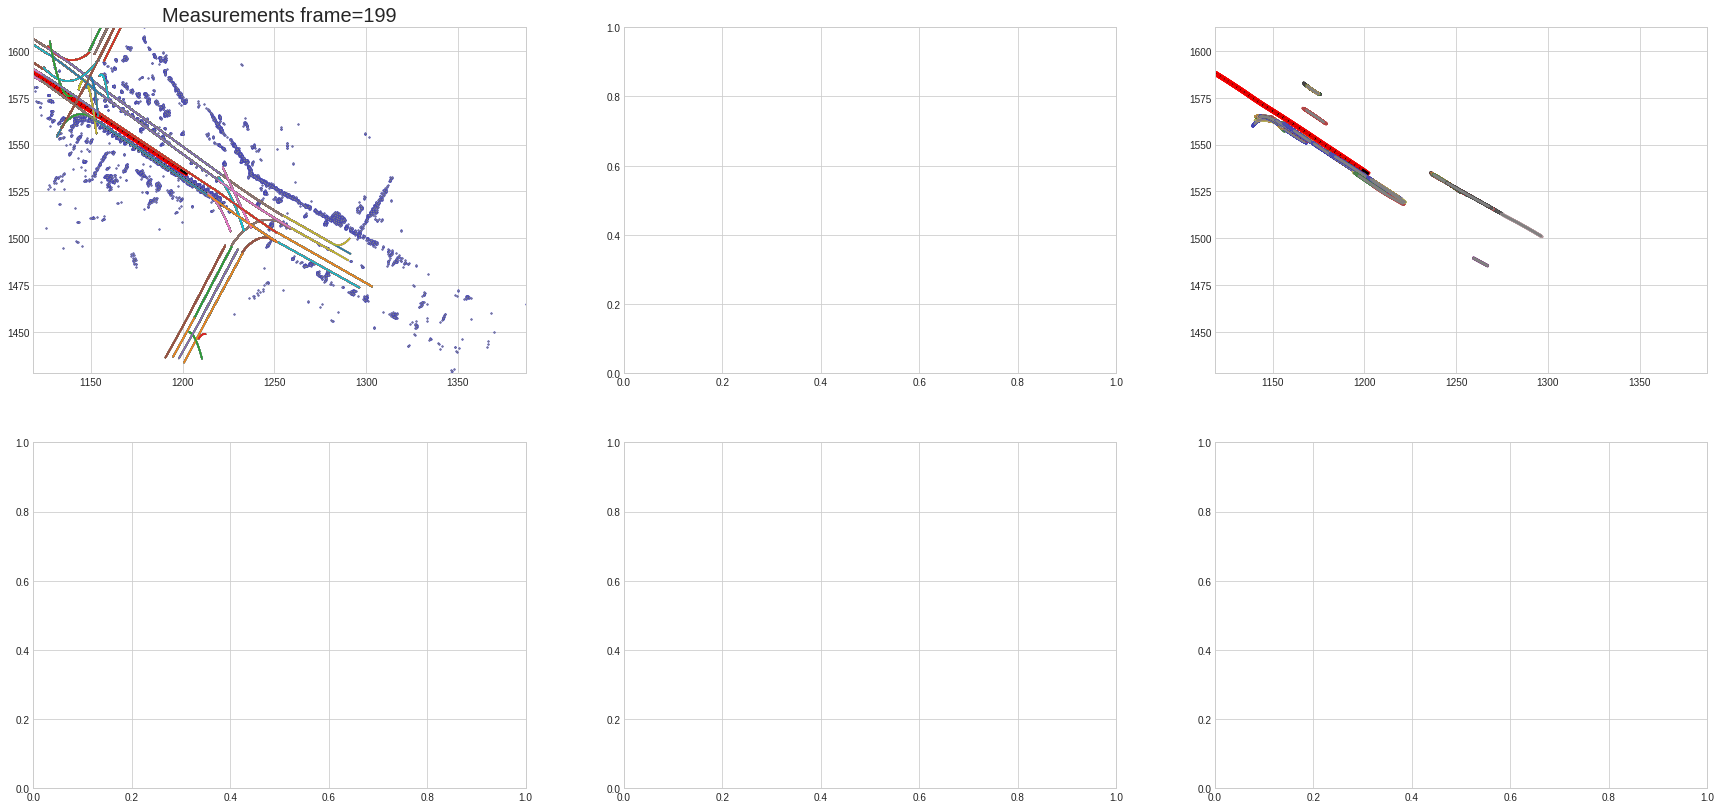

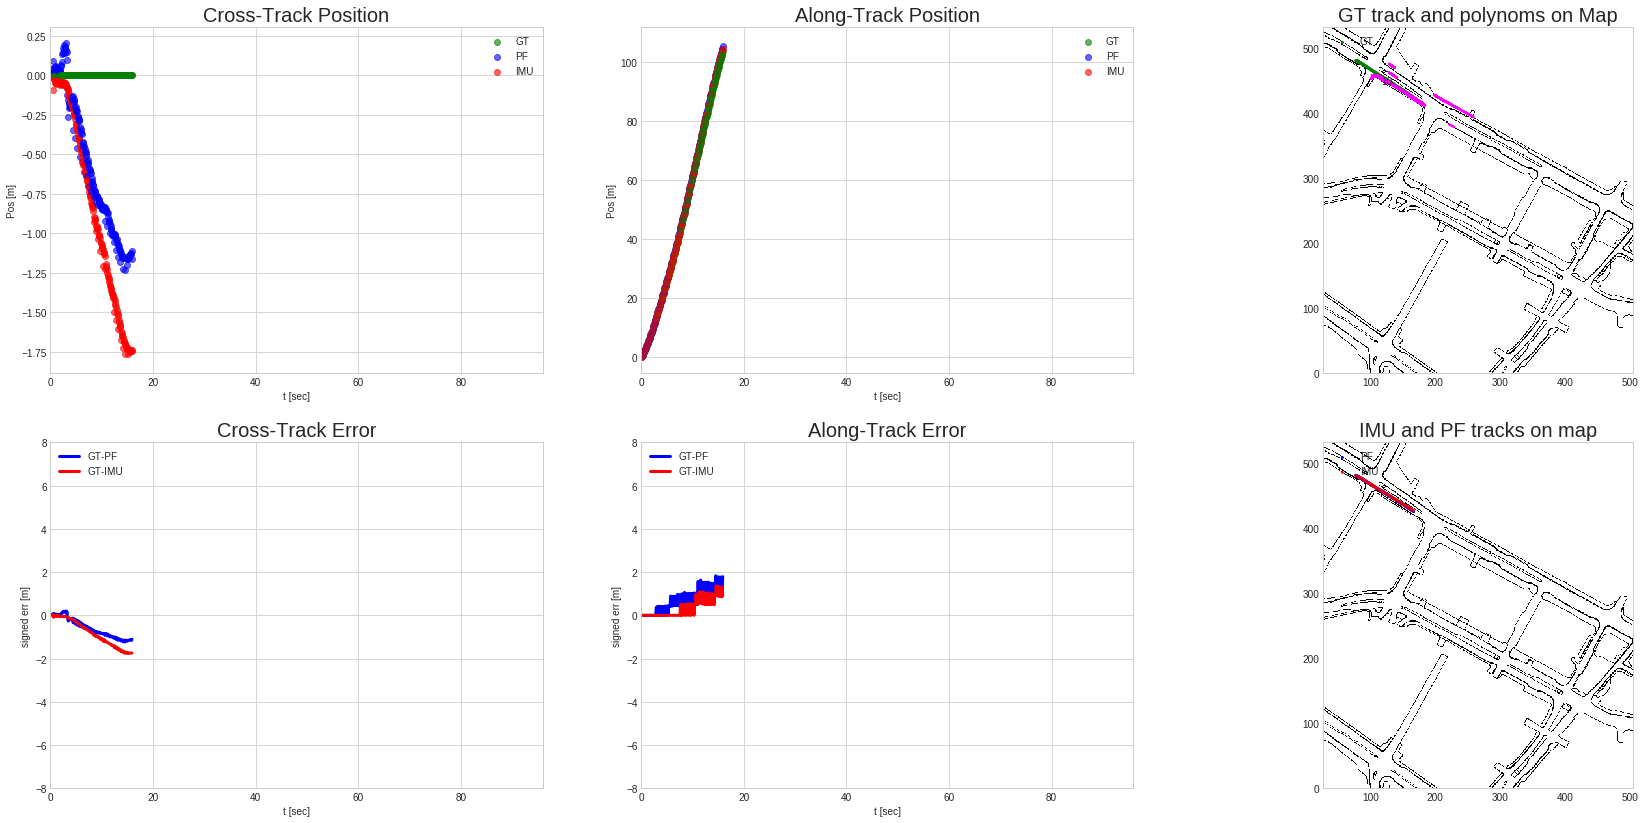

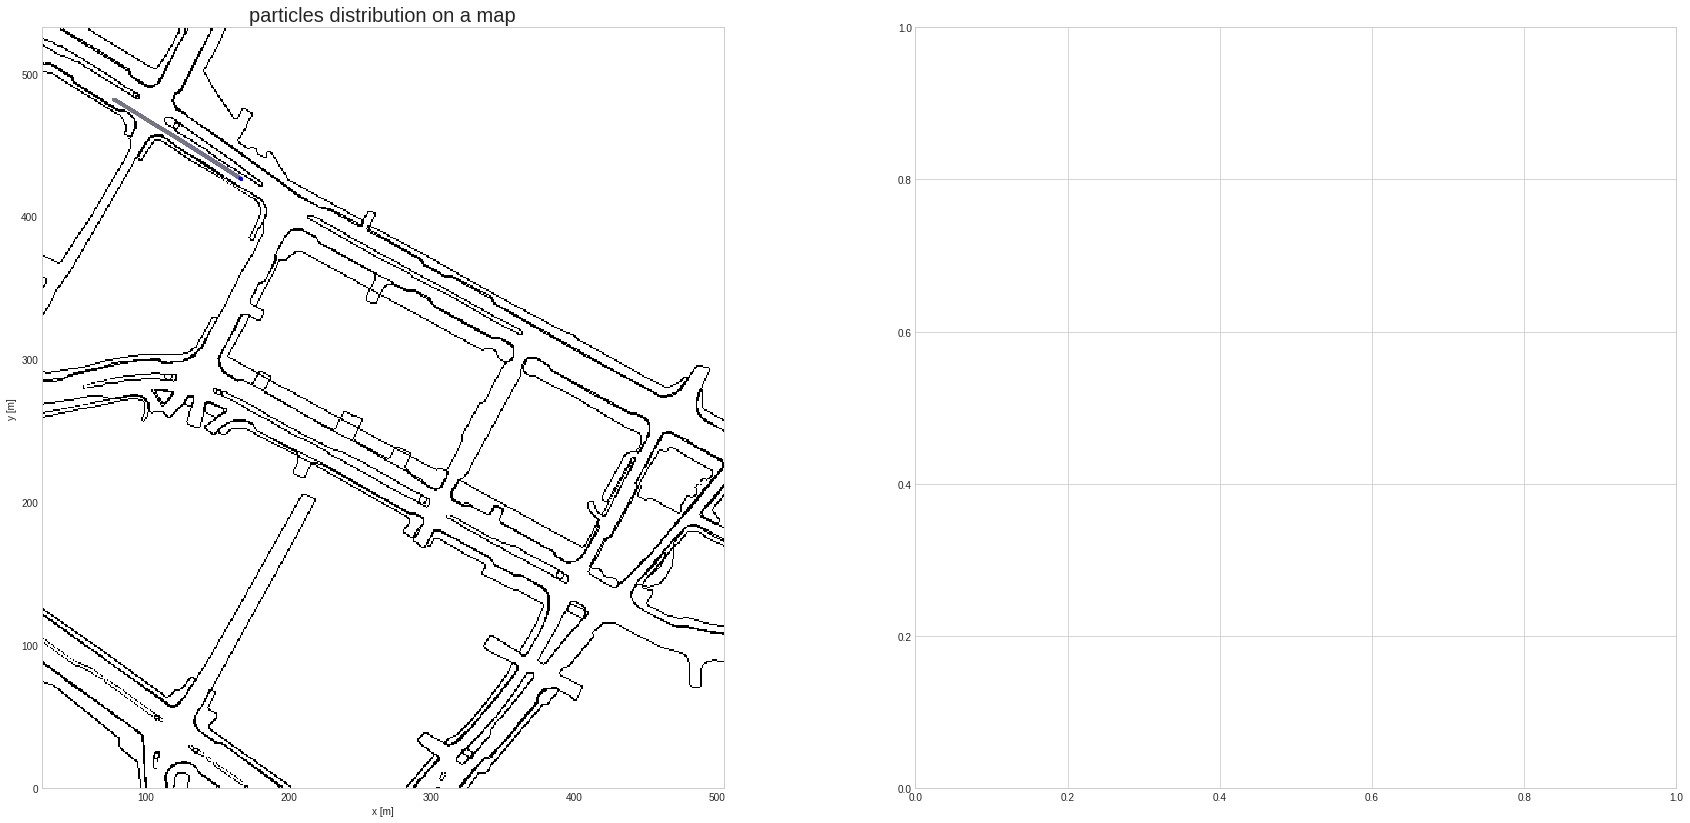

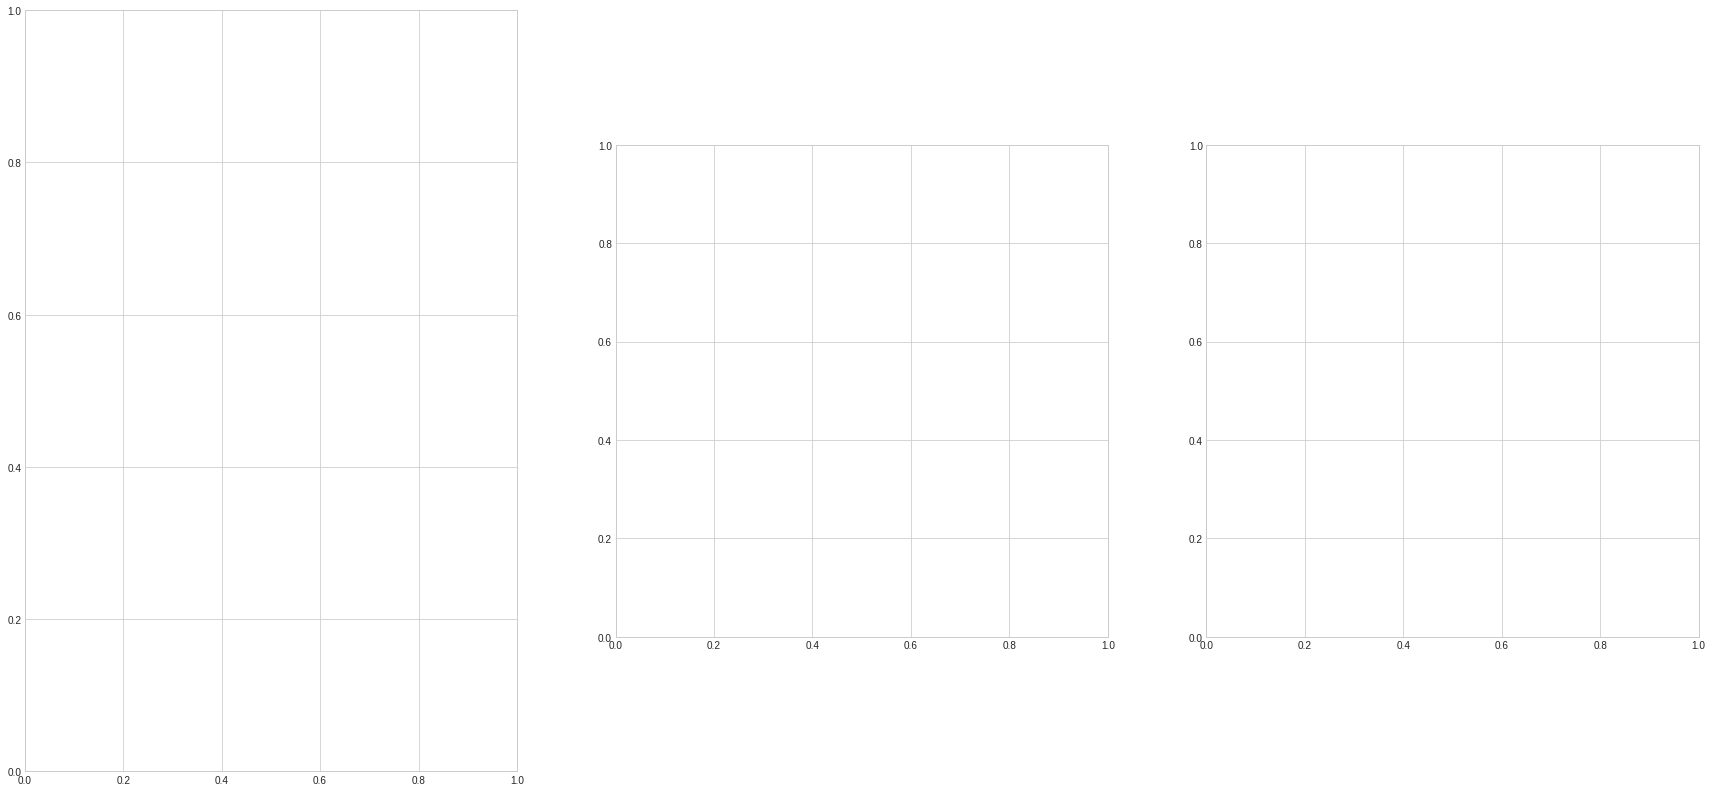

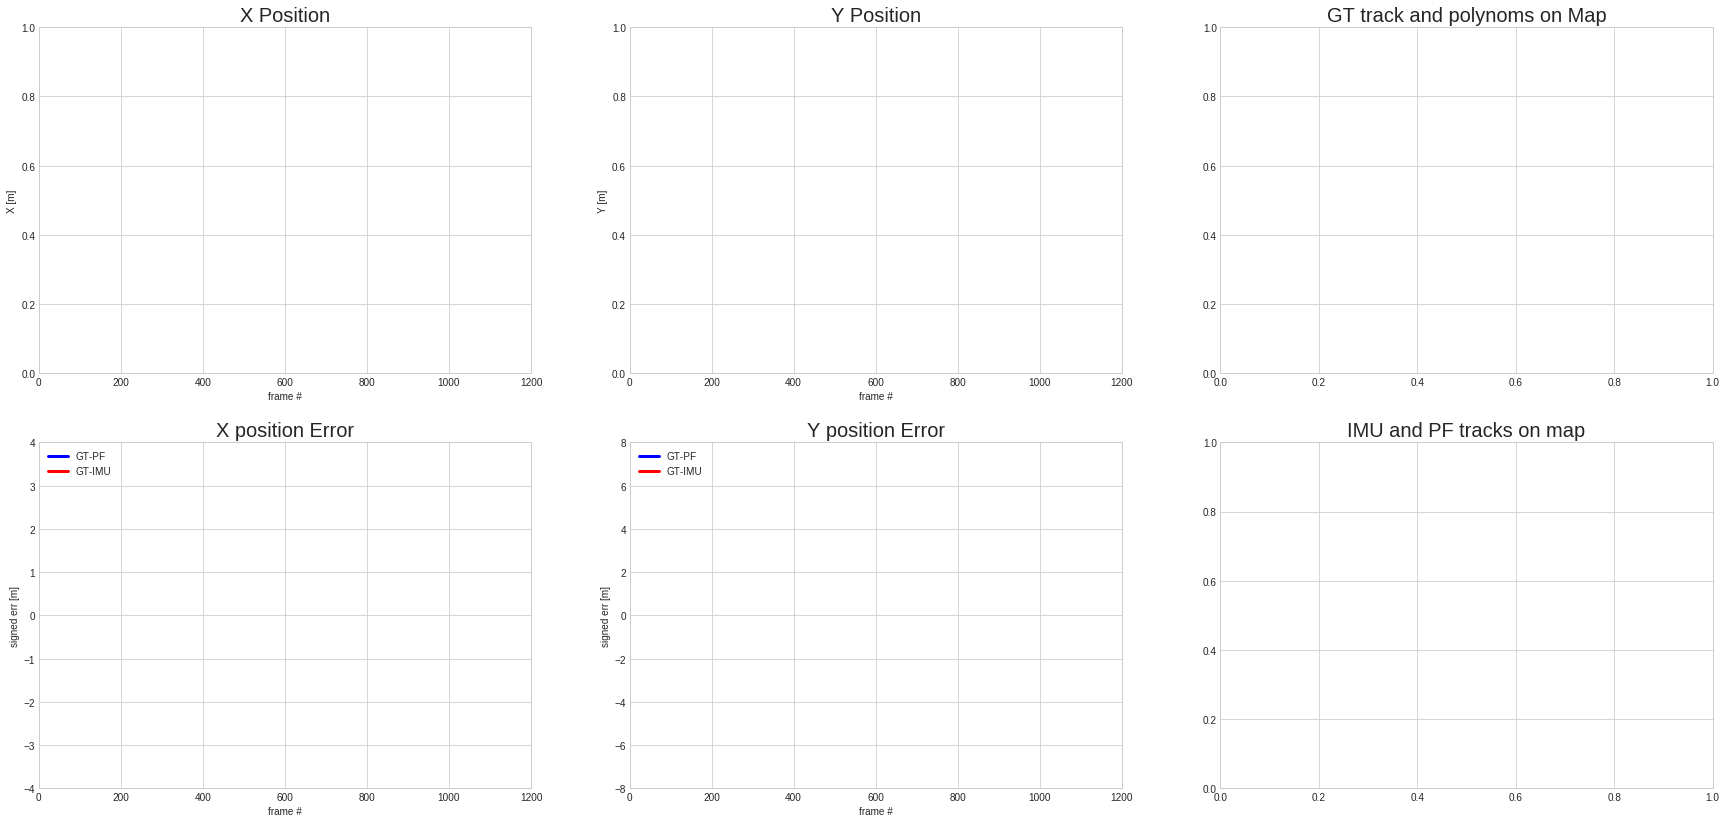

In [177]:
scene = 690 #365
model = RadarLocalizer(scene_id=scene, mm=True)
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list={'video' : True, 'video_debug': True, 'video_pf': True, 'video_pf_xy': False})
sim.run(start=0, N=200, generate_video=False, video_with_priors=True, debug=False)

In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

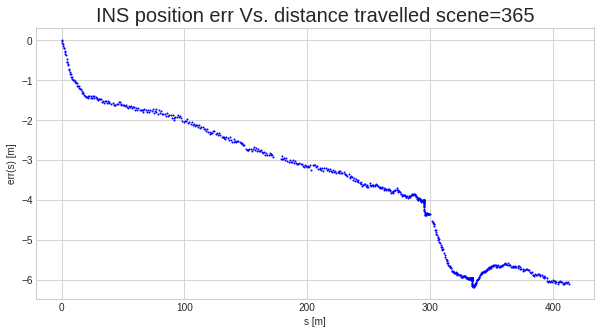

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


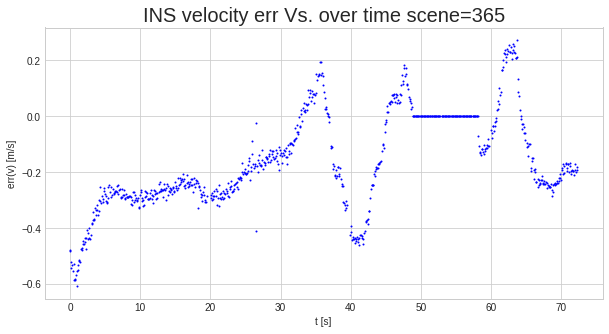

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
